In [1]:
import numpy as np
import pandas as pd

target_name_dict = {'astro-ph.GA' : 0,
                    'astro-ph.SR' : 1,
                    'astro-ph.IM' : 2,
                    'astro-ph.EP' : 3,
                    'astro-ph.HE' : 4,
                    'astro-ph.CO' : 5
                }
label2target = { v:k for k,v in target_name_dict.items()}

In [2]:
df = pd.HDFStore("../data/2014astroph_p.h5", "r")
df['/df'].keys()
abstracts = df['/df']['abstract']
labels = np.array(df['/df']['label'])
df.close()

In [3]:
j = np.random.randint(len(labels))
print(j, label2target[labels[j]])
print(abstracts[j])

6211 astro-ph.HE
Very recently, the IceCube Collaboration reported a flux of neutrinos in the
energy range 50 TeV < E_\nu < 2 PeV, which departs from expectations from
atmospheric background at the 5.7\sigma level. This flux is in remarkable
agreement with the expected diffuse flux of neutrinos from starburst galaxies,
and the 3 highest energy events have uncertainty contours encompassing some of
such systems. These events, all of which have well-measured energies above 1
PeV, exhibit shower topologies, for which the angular resolution is about
15^\circ. Due to this angular uncertainty and the a posteriori nature of cuts
used in our study it is not possible to assign a robust statistical
significance to this association. Using muon tracks, which have angular
resolution < 1^\circ, we compute the number of observations required to make a
statistically significant statement, and show that in a few years of operation
the upgraded IceCube detector should be able to confirm or refute this
hy

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [5]:
# settings
maxlen = 150
max_words = 10000 # Top 10000 words
training_samples = 6000 #

In [6]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(abstracts)
sequences = tokenizer.texts_to_sequences(abstracts)
word_index = tokenizer.word_index

print("Found %s unique tokens" % len(word_index))

word_index_reverse = dict()

for k, v in word_index.items():
    word_index_reverse[v] = k

Found 30677 unique tokens


In [7]:
data = pad_sequences(sequences=sequences, maxlen=maxlen)
indices = np.arange(abstracts.shape[0])

np.random.seed(1234)

np.random.shuffle(indices)

data = data[indices]

labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_test = data[training_samples:]
y_test = labels[training_samples:]

In [8]:
#https://stackoverflow.com/questions/41971587/how-to-convert-predicted-sequence-back-to-text-in-keras
# Creating a reverse dictionary
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

# Creating texts 
my_texts = list(map(sequence_to_text, data))

# alternative way
my_texts_2 = tokenizer.sequences_to_texts(sequences=sequences)

In [9]:
j = np.random.randint(len(x_train))
print(j, label2target[y_train[j]])
print(my_texts[j])

2788 astro-ph.CO
['ia', 'data', 'in', 'recent', 'years', 'we', 'use', 'the', 'union2', '1', 'data', 'to', 'give', 'a', 'simple', 'classification', 'of', 'such', 'studies', 'for', 'the', 'first', 'time', 'because', 'the', 'maximum', 'anisotropic', 'direction', 'is', 'independent', 'of', 'isotropic', 'dark', 'energy', 'models', 'we', 'adopt', 'two', 'cosmological', 'models', 'lambda', 'cdm', 'w', 'cdm', 'for', 'the', 'hemisphere', 'comparison', 'analysis', 'and', 'lambda', 'cdm', 'model', 'for', 'dipole', 'fit', 'approach', 'in', 'hemisphere', 'comparison', 'method', 'the', 'matter', 'density', 'and', 'the', 'equation', 'of', 'state', 'of', 'dark', 'energy', 'are', 'adopted', 'as', 'the', 'diagnostic', 'in', 'the', 'lambda', 'cdm', 'model', 'and', 'w', 'cdm', 'model', 'respectively', 'in', 'dipole', 'fit', 'approach', 'we', 'fit', 'the', 'fluctuation', 'of', 'distance', 'modulus', 'we', 'find', 'that', 'there', 'is', 'a', 'null', 'signal', 'for', 'the', 'hemisphere', 'comparison', 'metho

In [10]:
from keras.utils.np_utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [11]:
from keras.models import Sequential
import keras.layers as layers

In [71]:
model = Sequential()
embeddings_dim = 100
model.add(layers.Embedding(max_words, embeddings_dim, input_length=maxlen))
#model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu', input_shape=(maxlen,)))
model.add(layers.LSTM(64))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 150, 100)          1000000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 390       
Total params: 1,042,630
Trainable params: 1,042,630
Non-trainable params: 0
_________________________________________________________________


In [72]:
#model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable= False

In [73]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train_one_hot,
                   epochs=5,
                   batch_size=32,
                   validation_split=0.3)
#model.save_weights('pre_trained_glove_model_2.h5')

Train on 4200 samples, validate on 1800 samples
Epoch 1/5
4200/4200 [==============================] - 16s 4ms/step - loss: 1.5595 - acc: 0.3864 - val_loss: 1.4766 - val_acc: 0.4678
Epoch 2/5
4200/4200 [==============================] - 15s 4ms/step - loss: 1.2644 - acc: 0.5000 - val_loss: 1.3047 - val_acc: 0.4944
Epoch 3/5
4200/4200 [==============================] - 15s 4ms/step - loss: 1.0332 - acc: 0.5940 - val_loss: 1.1805 - val_acc: 0.5250
Epoch 4/5
4200/4200 [==============================] - 15s 4ms/step - loss: 0.8085 - acc: 0.7060 - val_loss: 1.9787 - val_acc: 0.5111
Epoch 5/5
4200/4200 [==============================] - 15s 4ms/step - loss: 0.6150 - acc: 0.8005 - val_loss: 1.0763 - val_acc: 0.6339


In [74]:
results = model.evaluate(x_test, y_test_one_hot)
class_prediction = model.predict_classes(x_test)

2794/2794 [==============================] - 3s 1ms/step


In [75]:
results

[1.0936648792766552, 0.6270579813460239]

In [76]:
jj = np.random.randint(len(x_test))
print(x_test[jj])
print(my_texts[training_samples+jj])
print(label2target[y_test[jj]])
print("prediction: ", label2target[class_prediction[jj]])

[   0    0    0    0    0    0    0    0    0    0    1 2582 1408    8
  674    6    4  793 2192 2405 2670  124   64  554   13   47   34  142
   16    8  138    6    1  302    2    4  149 5131  184   32   84   10
   47   34    3 1929  716    5   16  561    4 2455 2686  368 4730    1
 1925    2 2582    1  582 2686 2203 8308   84   10 1929    3   78 1929
  186   12  256  315    9  240  144   13   40    1 2582   47   34   26
    9    1  295  804 1139   18    1  229 2063 1001    5    1 1929  205
   73    2    1   52  144 2582 8308    8 2949   15    1 1181 5022 7485
   84   10    1 2686 2582 1229    3    1 2582 1929   26   35    8   45
 1917  844   16 2686 1229  513    4 6338  163 2121    2  838  681   94
   15    1  660    2    4   81 1635   17 2914  818]
[None, None, None, None, None, None, None, None, None, None, 'the', 'holographic', 'principle', 'is', 'applied', 'to', 'a', 'flat', 'friedmann', 'robertson', 'walker', 'space', 'time', 'dominated', 'by', 'dark', 'energy', 'when', 'this', 

In [78]:
abstract_testing = "we formulate a set of linear equations that describe the behaviour of small eccentricities in a protoplanetary system consisting of a gaseous disc and a planet."
seq_testing = tokenizer.texts_to_sequences([[ w for w in abstract_testing.split(' ')]])
data_testing = pad_sequences(sequences=seq_testing, maxlen=maxlen)
print(data_testing)
classes_testing = model.predict(data_testing)
print("prediction: ", classes_testing[0])
print("predicted category: ", label2target[np.argmax(classes_testing[0])])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    7
  5063    4  310    2  285  409   11  568    1 1272    2  147 3026    5
     4 1735  118 1890    2    4 1995  505    3    4]]
prediction:  [0.04826705 0.08450519 0.4984524  0.3305419  0.01982433 0.0184091 ]
predicted category:  astro-ph.IM


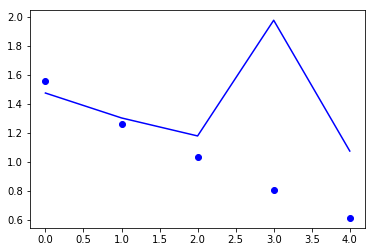

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.epoch, history.history['loss'], 'bo')
ax.plot(history.epoch, history.history['val_loss'], 'b')